# comparng varimax to spectral clustering

In [3]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)


import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_names.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))


G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51
10


ValueError: Shape of passed values is (9661, 9), indices imply (348, 9)

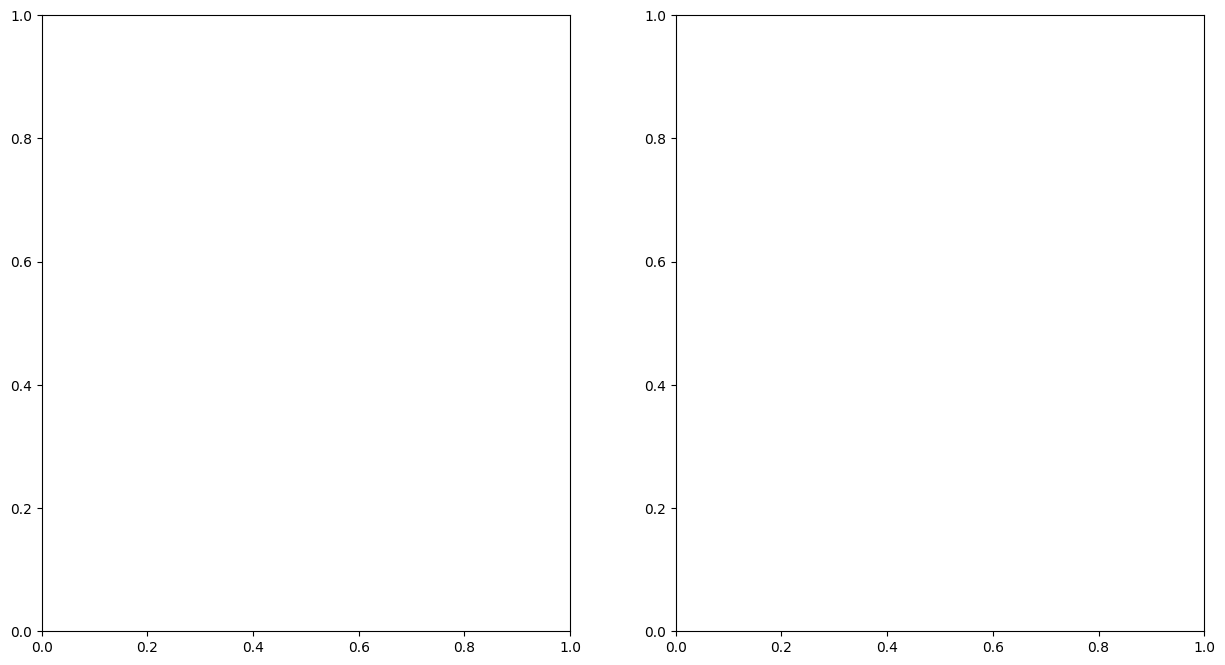

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from scipy.stats import zscore
from sklearn.cluster import SpectralClustering  # Add this import



def varimax_rotation(loadings, max_iter=1000, tol=1e-6):
    """Apply varimax rotation to loadings matrix"""
    n_rows, n_cols = loadings.shape
    rotation = np.eye(n_cols)
    
    var_old = 0
    for _ in range(max_iter):
        basis = loadings @ rotation
        h = basis ** 2
        mu = h.mean(axis=0, keepdims=True)
        term1 = basis ** 3
        term2 = basis @ np.diag(mu.squeeze())
        u = term1 - term2 @ np.ones((n_cols, n_cols)) / n_cols
        
        gradient = loadings.T @ u
        U, S, Vh = np.linalg.svd(gradient)
        rotation = U @ Vh
        
        var_new = np.sum(h ** 2)
        if np.abs(var_new - var_old) < tol:
            break
        var_old = var_new
    
    return loadings @ rotation

def compare_clustering_methods():
    # Average disease trajectories
    Y_avg = torch.mean(Y_tensor, dim=2).numpy()
    
    # 1. Varimax approach
    # First do PCA
    pca = PCA(n_components=K-1)
    Y_pca = pca.fit_transform(StandardScaler().fit_transform(Y_avg))
    
    # Apply varimax rotation
    rotated_loadings = varimax_rotation(Y_pca)
    
    # Assign diseases to clusters based on highest loading
    varimax_clusters = np.argmax(np.abs(rotated_loadings), axis=1)
    
    # 2. Spectral clustering approach
    # Compute correlation and similarity
    corr_matrix = np.corrcoef(Y_avg.T)
    similarity = (corr_matrix + 1) / 2
    
    # Apply spectral clustering
    spectral = SpectralClustering(
        n_clusters=K-1,
        assign_labels='kmeans',
        affinity='precomputed',
        random_state=42
    ).fit(similarity)
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    # Plot Varimax clusters
    sns.heatmap(pd.DataFrame(
        rotated_loadings, 
        index=disease_names.values.flatten()
    ), ax=ax1, cmap='RdBu_r')
    ax1.set_title('Varimax Loadings')
    ax1.set_xlabel('Components')
    ax1.set_ylabel('Diseases')
    
    # Plot Spectral clusters
    cluster_matrix = np.zeros((len(disease_names), K-1))
    for i, cluster in enumerate(spectral.labels_):
        cluster_matrix[i, cluster] = 1
        
    sns.heatmap(pd.DataFrame(
        cluster_matrix,
        index=disease_names.values.flatten()
    ), ax=ax2, cmap='binary')
    ax2.set_title('Spectral Clusters')
    ax2.set_xlabel('Clusters')
    ax2.set_ylabel('Diseases')
    
    plt.tight_layout()
    
    # Print cluster assignments
    print("\nVarimax Disease Groups:")
    for k in range(K-1):
        diseases = disease_names.values.flatten()[varimax_clusters == k]
        print(f"\nComponent {k}:")
        print(diseases)
        
    print("\nSpectral Disease Groups:")
    for k in range(K-1):
        diseases = disease_names.values.flatten()[spectral.labels_ == k]
        print(f"\nCluster {k}:")
        print(diseases)
    
    return varimax_clusters, spectral.labels_, rotated_loadings

# Run comparison
varimax_clusters, spectral_clusters, varimax_loadings = compare_clustering_methods()